# Histogram oriented gradients

HOG, или Histogram of Oriented Gradients, это дескриптор признаков, который часто используется для извлечения признаков из изображения. Это широко используется в задачах компьютерного зрения. Этот метод подсчитывает появления градиентной ориентации в отдельных участках изображения

HOG дескриптор фокусируется на структуре или форме объекта. Для признаков границ мы только отмечаем, является ли данный пиксель границей или нет. HOG способен также предоставить направление границы. Это делается путем извлечения градиента и ориентации (или можно сказать мощность и направление) границ.


In [1]:
%pip install python-dotenv boto3 pillow pandas matplotlib catboost

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [1]:
%load_ext dotenv
%dotenv
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import boto3
import catboost as cb
from warnings import filterwarnings
filterwarnings("ignore")
import os
os.environ["PYTHONWARNINGS"] = "ignore"

s3_client = boto3.client(
    's3',
    endpoint_url='https://storage.yandexcloud.net',
    aws_access_key_id=os.getenv('AWS_ACCESS_KEY_ID'),
    aws_secret_access_key=os.getenv('AWS_SECRET_ACCESS_KEY'),
)
BUCKET_NAME = 'tnn-hse-medtech'
DATASET_DIR = 'datasets/'


cannot find .env file


Считываем таблицу с обработанными данными на этапе [EDA](../../EDA.md)

In [3]:
data = pd.read_csv('normalized_data.csv')


Перед извлечением HOG-дескриптора приводим изображение к оттенкам серого и уменьшаем до размера 128x128.

In [4]:
import io
from skimage.feature import hog
from PIL import Image

def hog_picture(image: io.IOBase):
    image = Image.open(image).convert('L').resize((128, 128))
    array = np.asarray(image)
    vector, hog_image = hog(
        array,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        feature_vector=True,
        visualize=True,
    )
    return vector, hog_image


Запускаем сбор дескрипторов

In [5]:
import io
from dataclasses import dataclass
from concurrent.futures import ThreadPoolExecutor
from ipywidgets import IntProgress
from IPython.display import display

@dataclass()
class Metadata:
    severity: int
    relative_path: str
    hog: np.ndarray
    hog_image: np.ndarray

def handle_file(item) -> Metadata:
    buffer = io.BytesIO()
    s3_client.download_fileobj(BUCKET_NAME, f'{DATASET_DIR}{item.relative_path}', buffer)
    buffer.seek(0)
    hog_fd, hog_image = hog_picture(buffer)
    return Metadata(item.severity, item.relative_path, hog_fd, hog_image)

raw_data = []
progress = IntProgress(min=0, max=len(data))
display(progress)
with ThreadPoolExecutor(max_workers=100) as pool:
    for item in pool.map(handle_file, data.itertuples(), chunksize=1):
        raw_data.append(item)
        progress.value += 1


IntProgress(value=0, max=3278)

Создаем датасеты

In [6]:
X_data = pd.DataFrame(data=(item.hog for item in raw_data))
y_target = pd.DataFrame(data=(item.severity for item in raw_data))


In [7]:
X_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3278 entries, 0 to 3277
Columns: 8100 entries, 0 to 8099
dtypes: float64(8100)
memory usage: 202.6 MB


Посмотрим на пример полученного дескриптора

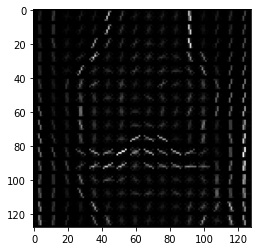

In [8]:
from skimage.exposure import rescale_intensity

hog_rescaled = rescale_intensity(raw_data[0].hog_image)
plt.imshow(hog_rescaled, cmap=plt.cm.gray)


Сохраняем датасет дескрипторов в S3

In [9]:
hog_data = X_data.copy()
hog_data['severity'] = y_target
buffer = io.BytesIO()
hog_data.to_csv(buffer, index=False, compression='gzip')
buffer.seek(0)
s3_client.upload_fileobj(buffer, BUCKET_NAME, 'csv/train_data.csv.gz')


Если нужно быстро получить hog_data, то нужно выполнить только этот блок

In [2]:
hog_data = pd.read_csv(f'https://storage.yandexcloud.net/{BUCKET_NAME}/csv/train_data.csv.gz', compression='gzip')
X_data = hog_data.drop(columns=['severity'])
y_target = hog_data['severity']


In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_data, y_target, test_size=0.3, stratify=y_target)


Подбираем гиперпараметры для модели SVC

In [12]:
%pip install scikit-learn-intelex

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for scikit-learn-intelex from https://files.pythonhosted.org/packages/ef/3d/cc9a1009e2239c739896aa097f29e12cc8b8a79ed293b4d75cc2980f413e/scikit_learn_intelex-2024.0.1-py310-none-manylinux1_x86_64.whl.metadata
  Obtaining dependency information for daal4py==2024.0.1 from https://files.pythonhosted.org/packages/a9/fa/af1756388a9e14428fe9c3e0b40cf3b28ccd51d55c1621e275d5f3977f53/daal4py-2024.0.1-py310-none-manylinux1_x86_64.whl.metadata
  Obtaining dependency information for daal==2024.0.1 from https://files.pythonhosted.org/packages/d7/c2/c5db19d1fb59641209499e87b0bcdb09e8f380cb9cda6babe1da05943714/daal-2024.0.1-py2.py3-none-manylinux1_x86_64.whl.metadata
  Obtaining dependency information for tbb==2021.* from https://files.pythonhosted.org/packages/31/fc/eeb2ab19f26e608bda910350b6f0a06e8dd1b472049b175ca36df93c81ff/tbb-2021.11.0-py2.py3-none-manylinux1_x86_64.whl.metadata
   ━━

In [5]:
from sklearnex import patch_sklearn
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

patch_sklearn()

params = {
    'C': np.linspace(1, 100, 3),
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'coef0': np.linspace(0, 10, 3),
    'class_weight': [None, 'balanced'],
    'decision_function_shape': ['ovo', 'ovr'],
}
gs_svc_model = GridSearchCV(SVC(probability=True), params, n_jobs=10, verbose=2, scoring='f1', cv=3)
gs_svc_model.fit(X_train, y_train)
gs_svc_model.best_params_, gs_svc_model.best_score_


Fitting 3 folds for each of 144 candidates, totalling 432 fits


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


[CV] END C=1.0, class_weight=None, coef0=0.0, decision_function_shape=ovo, kernel=poly; total time=  28.0s
[CV] END C=1.0, class_weight=None, coef0=0.0, decision_function_shape=ovo, kernel=sigmoid; total time=  27.8s
[CV] END C=1.0, class_weight=None, coef0=0.0, decision_function_shape=ovo, kernel=sigmoid; total time=  27.8s
[CV] END C=1.0, class_weight=None, coef0=0.0, decision_function_shape=ovo, kernel=sigmoid; total time=  29.1s
[CV] END C=1.0, class_weight=None, coef0=0.0, decision_function_shape=ovo, kernel=poly; total time=  28.9s
[CV] END C=1.0, class_weight=None, coef0=0.0, decision_function_shape=ovr, kernel=linear; total time=  28.4s
[CV] END C=1.0, class_weight=None, coef0=0.0, decision_function_shape=ovo, kernel=linear; total time=  28.0s
[CV] END C=1.0, class_weight=None, coef0=0.0, decision_function_shape=ovr, kernel=linear; total time=  29.4s
[CV] END C=1.0, class_weight=None, coef0=0.0, decision_function_shape=ovo, kernel=poly; total time=  27.9s
[CV] END C=1.0, class_

({'C': 1.0,
  'class_weight': None,
  'coef0': 0.0,
  'decision_function_shape': 'ovo',
  'kernel': 'linear'},
 nan)

In [6]:
gs_svc_model.best_estimator_


SVC(decision_function_shape='ovo', kernel='linear', probability=True)

In [7]:
from sklearn.metrics import f1_score, roc_auc_score
y_pred_proba = gs_svc_model.best_estimator_.predict_proba(X_test)
y_pred = gs_svc_model.best_estimator_.predict(X_test)
print('roc_auc:', roc_auc_score(y_test, y_pred_proba, multi_class='ovo'))
print('f1:', f1_score(y_test, y_pred, average='macro'))


roc_auc: 0.9532395652987941
f1: 0.9015054607362568


Модель показывает неплохие метрики качества. Попробуем использовать градиентный бустинг

In [8]:
%pip install catboost ipywidgets


Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.8/116.8 kB 1.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.3/780.3 kB 6.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 43.7 MB/s eta 0:00:0000:0100:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ml-kernel 0.0.1 requires requests==2.31.0, but you have requests 2.27.1 which is incompatible.

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [ ]:
!jupyter labextension install @jupyter-widgets/jupyterlab-manager jupyter-leaflet

In [11]:
#!g1.1
import catboost as cb

cb_model = cb.CatBoostClassifier(
    one_hot_max_size=50,
    iterations=1500,
    learning_rate=0.1,
    bootstrap_type='Bernoulli',
    subsample=0.5,
    task_type="GPU",
    devices='0:1',
    )
cb_model.fit(
    X_train, 
    y_train,
    verbose=False,
    plot=True,
    eval_set=(X_test, y_test)
    )


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [12]:
from sklearn.metrics import roc_auc_score, f1_score

y_pred_proba = cb_model.predict_proba(X_test)
y_pred = cb_model.predict(X_test)
print('roc_auc:', roc_auc_score(y_test, y_pred_proba, multi_class='ovo'))
print('f1:', f1_score(y_test, y_pred, average='macro'))


roc_auc: 0.9859712551824915
f1: 0.9111928709414137


In [13]:
cb_model.get_params()


{'iterations': 1500,
 'learning_rate': 0.1,
 'one_hot_max_size': 50,
 'task_type': 'GPU',
 'devices': '0:1',
 'bootstrap_type': 'Bernoulli',
 'subsample': 0.5}

In [14]:
cb_model.save_model('hog_cat_boost.cbm', format="cbm")
s3_client.upload_file('hog_cat_boost.cbm', BUCKET_NAME, 'models/hog_cat_boost.cbm')


In [15]:
%pip install hyperopt


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [ ]:
#!g1.1
import numpy as np
from hyperopt import hp, fmin, tpe
from catboost.utils import eval_metric

val_pool = cb.Pool(X_test, y_test)
train_pool = cb.Pool(X_train, y_train)

def hyperopt_objective(params):
    model = cb.CatBoostClassifier(
        loss_function='MultiClass',
        n_estimators=150,
        bootstrap_type='Bernoulli',
        subsample=0.5,
        task_type="GPU",
        devices='0:1',
        **params)
    model.fit(train_pool, verbose=0, eval_set=val_pool)
    y_pred = model.predict_proba(val_pool)
    return -eval_metric(val_pool.get_label(), y_pred, 'AUC')[0]

space = {
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.1),
    'depth': hp.randint('depth', 3, 10),
    'l2_leaf_reg': hp.uniform('l2_leaf_reg', 1, 100),
}

best = fmin(
    hyperopt_objective,
    space=space,
    algo=tpe.suggest,
    max_evals=1000,
    trials_save_file='hog_cb_trials.bin',
)


In [ ]:
best

In [18]:
best = {'depth': 9,
 'l2_leaf_reg': 1.0373073118412859,
 'learning_rate': 0.07}

In [20]:
#!g1.1
val_pool = cb.Pool(X_test, y_test)
train_pool = cb.Pool(X_train, y_train)
model = cb.CatBoostClassifier(
    loss_function='MultiClass',
    n_estimators=1500,
    bootstrap_type='Bernoulli',
    task_type="GPU",
    devices='0:1',
    **best,
)
model.fit(train_pool, verbose=0, eval_set=val_pool, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [21]:
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score

y_pred_proba = model.predict_proba(X_test)
y_pred = model.predict(X_test)
print('roc_auc:', roc_auc_score(y_test, y_pred_proba, multi_class='ovo'))
print('f1:', f1_score(y_test, y_pred, average='macro'))
print('accuracy:', accuracy_score(y_test, y_pred))

roc_auc: 0.9878293889932849
f1: 0.9029431793568014
accuracy: 0.899390243902439


После подбора параметров удалось немного увеличить качество предсказаний. Сохраним эту модель в S3, чтобы в будущем можно было использовать в сервисе

In [10]:
model.save_model('hog_cat_boost_v3.cbm', format="cbm")
s3_client.upload_file('hog_cat_boost_v3.cbm', BUCKET_NAME, 'models/hog_cat_boost_v3.cbm')

Проверим скорость предсказания на одной модели

In [22]:
from skimage.feature import hog
from PIL import Image
import io

def hog_picture(image: io.IOBase):
    image = Image.open(image).convert('L').resize((128, 128))
    array = np.asarray(image)
    vector = hog(
        array,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        feature_vector=True,
    )
    return vector

def predict(image: io.IOBase):
    vector = hog_picture(image)
    severity = model.predict(vector)
    return severity

Для этого используем спорные изображения, который получили разную оценку у экспертов и не использовались при обучении

In [23]:
buffer = io.BytesIO()
s3_client.download_fileobj(BUCKET_NAME, f'{DATASET_DIR}MedicalExpert-II/2Mild/MildG2 (110).png', buffer)
buffer.seek(0)

0

In [24]:
%%timeit
predict(buffer)

17.5 ms ± 222 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Модель предсказывает достаточно быстро для встраивания в API
